In [184]:
import os
import itertools
import glob
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker
import matplotlib.pyplot as plt


pal = sns.color_palette(['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'])
sns.set_palette(pal)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (4.5,2)
mpl.rcParams['figure.dpi'] = 100

In [185]:
# we have proper speedtest data only from 2022-03-03 to 2022-04-02
# start_date = '2022-03-03'
# end_date = '2022-04-02'

# we have rain from 2022-03-11 to 2022-03-17
# start_date = '2022-03-11'
# end_date = '2022-03-17'

# complete data
start_date = '2021-12-15'
end_date = '2022-12-15'

In [186]:
df_ping = pd.read_csv('./uclouvain-data/ping.csv')
df_ping['timestamp'] = pd.to_datetime(df_ping['timestamp'])

df_bandwidth = pd.read_csv('./uclouvain-data/speed-test.csv')
df_bandwidth['timestamp'] = pd.to_datetime(df_bandwidth['timestamp'])
# remove the stupid timezone
df_bandwidth['timestamp'] = df_bandwidth['timestamp'].dt.tz_localize(None)

df_weather = pd.read_csv('./weather.csv')
df_weather['timestamp'] = pd.to_datetime(df_weather['time'])
df_weather = df_weather.drop(columns=['time'])

In [187]:
df_weather.head()

,temperature_2m_C,precipitation_mm,rain_mm,weathercode,cloudcover_perc,cloudcover_low_perc,cloudcover_mid_perc,cloudcover_high_perc,timestamp
0,7.6,0.0,0.0,3,100,100,0,98,2021-12-15 00:00:00
1,7.6,0.0,0.0,3,100,100,0,99,2021-12-15 01:00:00
2,7.5,0.0,0.0,3,100,100,0,87,2021-12-15 02:00:00
3,7.5,0.0,0.0,3,100,100,0,39,2021-12-15 03:00:00
4,7.4,0.0,0.0,3,90,100,0,0,2021-12-15 04:00:00


In [188]:
# get relevant data
df_ping = df_ping[df_ping['timestamp'] > start_date]
df_ping = df_ping[df_ping['timestamp'] < end_date]
print(df_ping.head())

df_bandwidth = df_bandwidth[df_bandwidth['timestamp'] > start_date]
df_bandwidth = df_bandwidth[df_bandwidth['timestamp'] < end_date]
print(df_bandwidth.head())

df_weather = df_weather[df_weather['timestamp'] > start_date]
df_weather = df_weather[df_weather['timestamp'] < end_date]
print(df_weather.head())

    type                     timestamp  bytes  response_ip  icmp_seq  ttl  \
0  reply 2022-03-26 00:00:01.809998080     64  193.0.19.59         1   55   
1  reply 2022-03-26 00:00:02.785553920     64  193.0.19.59         2   55   
2  reply 2022-03-26 00:00:03.801693952     64  193.0.19.59         3   55   
3  reply 2022-03-26 00:00:28.224142080     64  193.0.19.60         1   56   
4  reply 2022-03-26 00:00:29.215565824     64  193.0.19.60         2   56   

   time_ms  duplicate  
0     69.9      False  
1     44.5      False  
2     59.1      False  
3     72.0      False  
4     62.4      False  
     type           timestamp  packetLoss       isp  ping_jitter  \
0  result 2022-01-06 00:26:08    0.000000  Starlink        1.346   
1  result 2022-01-06 00:43:52    0.000000  Starlink        4.194   
2  result 2022-01-06 01:26:14    0.333333  Starlink        2.711   
3  result 2022-01-06 02:02:39    0.000000  Starlink        2.013   
4  result 2022-01-06 02:26:07    0.000000  Starlink  

In [189]:
# get the 99th percentile of the ping to find outliers
df_ping['time_ms'].quantile(0.99)

352.0

In [190]:
# remove outliers
df_ping = df_ping[df_ping['time_ms'] < df_ping['time_ms'].quantile(0.99)]

In [191]:
# the weather data we have is hourly
# so our other data needs to be aggregated to the same level
df_ping_mean = df_ping.groupby(pd.Grouper(key='timestamp', freq='H')).mean()
df_bandwidth_mean = df_bandwidth.groupby(pd.Grouper(key='timestamp', freq='H')).mean()

# but mean is not enough, we also need 25th and 75th percentile
df_ping_25 = df_ping.groupby(pd.Grouper(key='timestamp', freq='H')).quantile(0.25)
df_ping_75 = df_ping.groupby(pd.Grouper(key='timestamp', freq='H')).quantile(0.75)
df_bandwidth_25 = df_bandwidth.groupby(pd.Grouper(key='timestamp', freq='H')).quantile(0.25)
df_bandwidth_75 = df_bandwidth.groupby(pd.Grouper(key='timestamp', freq='H')).quantile(0.75)

/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_70686/33518748.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_ping_mean = df_ping.groupby(pd.Grouper(key='timestamp', freq='H')).mean()
/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_70686/33518748.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_bandwidth_mean = df_bandwidth.groupby(pd.Grouper(key='timestamp', freq='H')).mean()
/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_70686/33518748.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, nume

Text(0, 0.5, 'Precipitation (mm/h)')

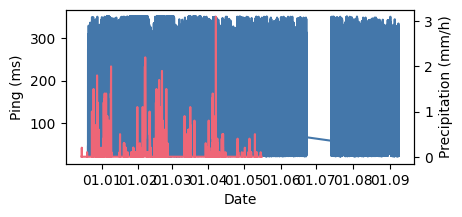

In [192]:
# precipitation and ping?
fig, ax = plt.subplots()
sns.lineplot(data=df_ping, x='timestamp', y='time_ms', ax=ax, color=pal[0])
ax.set_ylabel('Ping (ms)')
ax.set_xlabel('Date')
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d.%m'))

ax2 = ax.twinx()
sns.lineplot(data=df_weather, x='timestamp', y='precipitation_mm', ax=ax2, color=pal[1])
ax2.set_ylabel('Precipitation (mm/h)')

Text(0, 0.5, 'Rain (mm/h)')

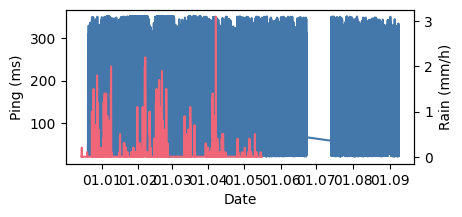

In [193]:
# rain and ping?
fig, ax = plt.subplots()
sns.lineplot(data=df_ping, x='timestamp', y='time_ms', ax=ax, color=pal[0])
ax.set_ylabel('Ping (ms)')
ax.set_xlabel('Date')
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d.%m'))

ax2 = ax.twinx()
sns.lineplot(data=df_weather, x='timestamp', y='rain_mm', ax=ax2, color=pal[1])
ax2.set_ylabel('Rain (mm/h)')

Text(0, 0.5, 'Cloud Cover (%)')

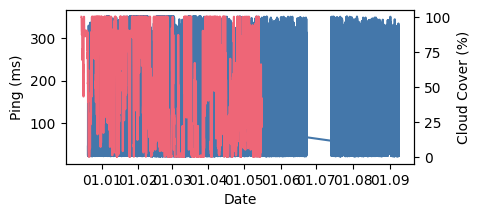

In [194]:
# cloud cover and ping?
fig, ax = plt.subplots()
sns.lineplot(data=df_ping, x='timestamp', y='time_ms', ax=ax, color=pal[0])
ax.set_ylabel('Ping (ms)')
ax.set_xlabel('Date')
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d.%m'))

ax2 = ax.twinx()
sns.lineplot(data=df_weather, x='timestamp', y='cloudcover_perc', ax=ax2, color=pal[1])
ax2.set_ylabel('Cloud Cover (%)')

Text(0, 0.5, 'Precipitation (mm/h)')

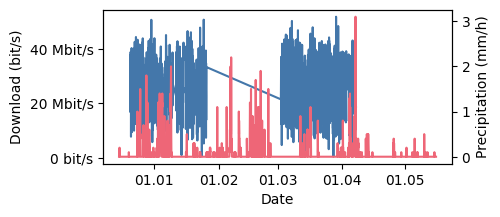

In [195]:
# precipitation and download?
fig, ax = plt.subplots()
sns.lineplot(data=df_bandwidth, x='timestamp', y='download_bandwidth',  ax=ax, color=pal[0])
ax.set_ylabel('Download (bit/s)')
ax.set_xlabel('Date')
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d.%m'))
ax.yaxis.set_major_formatter(mpl.ticker.EngFormatter(unit='bit/s'))

ax2 = ax.twinx()
sns.lineplot(data=df_weather, x='timestamp', y='precipitation_mm', ax=ax2, color=pal[1])
ax2.set_ylabel('Precipitation (mm/h)')

Text(0, 0.5, 'Rain (mm/h)')

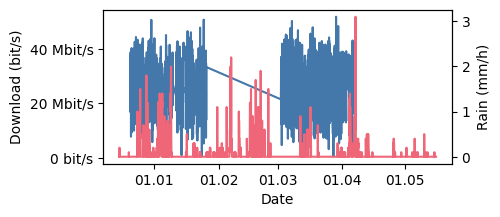

In [196]:
# rain and download?
fig, ax = plt.subplots()
sns.lineplot(data=df_bandwidth, x='timestamp', y='download_bandwidth',  ax=ax, color=pal[0])
ax.set_ylabel('Download (bit/s)')
ax.set_xlabel('Date')
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d.%m'))
ax.yaxis.set_major_formatter(mpl.ticker.EngFormatter(unit='bit/s'))

ax2 = ax.twinx()
sns.lineplot(data=df_weather, x='timestamp', y='rain_mm', ax=ax2, color=pal[1])
ax2.set_ylabel('Rain (mm/h)')

Text(0, 0.5, 'Cloud Cover (%)')

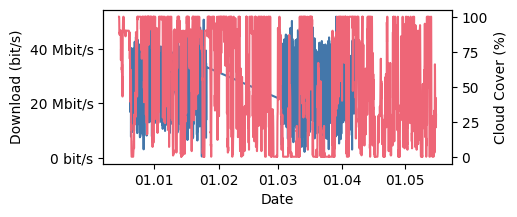

In [197]:
# cloud cover and download?
fig, ax = plt.subplots()
sns.lineplot(data=df_bandwidth, x='timestamp', y='download_bandwidth',  ax=ax, color=pal[0])
ax.set_ylabel('Download (bit/s)')
ax.set_xlabel('Date')
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d.%m'))
ax.yaxis.set_major_formatter(mpl.ticker.EngFormatter(unit='bit/s'))

ax2 = ax.twinx()
sns.lineplot(data=df_weather, x='timestamp', y='cloudcover_perc', ax=ax2, color=pal[1])
ax2.set_ylabel('Cloud Cover (%)')

Text(0, 0.5, 'Precipitation (mm/h)')

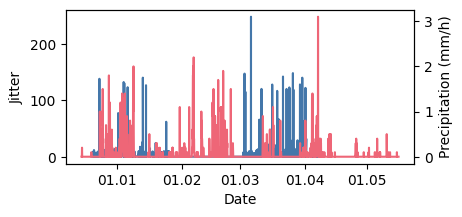

In [198]:
# cloud cover and jitter?
fig, ax = plt.subplots()
sns.lineplot(data=df_bandwidth, x='timestamp', y='ping_jitter',  ax=ax, color=pal[0])
ax.set_ylabel('Jitter')
ax.set_xlabel('Date')
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d.%m'))

ax2 = ax.twinx()
sns.lineplot(data=df_weather, x='timestamp', y='precipitation_mm', ax=ax2, color=pal[1])
ax2.set_ylabel('Precipitation (mm/h)')

Text(0, 0.5, 'Rain (mm/h)')

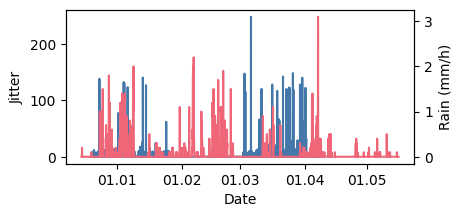

In [199]:
# cloud cover and jitter?
fig, ax = plt.subplots()
sns.lineplot(data=df_bandwidth, x='timestamp', y='ping_jitter',  ax=ax, color=pal[0])
ax.set_ylabel('Jitter')
ax.set_xlabel('Date')
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d.%m'))

ax2 = ax.twinx()
sns.lineplot(data=df_weather, x='timestamp', y='rain_mm', ax=ax2, color=pal[1])
ax2.set_ylabel('Rain (mm/h)')

Text(0, 0.5, 'Cloud Cover (%)')

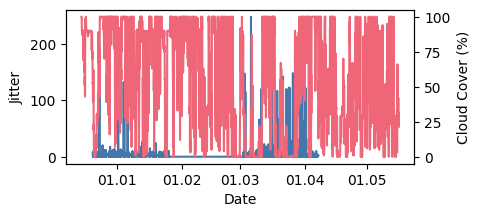

In [200]:
# cloud cover and jitter?
fig, ax = plt.subplots()
sns.lineplot(data=df_bandwidth, x='timestamp', y='ping_jitter',  ax=ax, color=pal[0])
ax.set_ylabel('Jitter')
ax.set_xlabel('Date')
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d.%m'))

ax2 = ax.twinx()
sns.lineplot(data=df_weather, x='timestamp', y='cloudcover_perc', ax=ax2, color=pal[1])
ax2.set_ylabel('Cloud Cover (%)')

In [201]:
df_weather.sort_values(by='timestamp', inplace=True)
df_ping.sort_values(by='timestamp', inplace=True)
df_bandwidth.sort_values(by='timestamp', inplace=True)

In [202]:
combined_ping_df = pd.merge_asof(df_weather, df_ping, on='timestamp', direction='nearest')

combined_ping_df.head()

,temperature_2m_C,precipitation_mm,rain_mm,weathercode,cloudcover_perc,cloudcover_low_perc,cloudcover_mid_perc,cloudcover_high_perc,timestamp,type,bytes,response_ip,icmp_seq,ttl,time_ms,duplicate
0,7.6,0.0,0.0,3,100,100,0,99,2021-12-15 01:00:00,reply,64,193.0.19.59,1,54,43.8,False
1,7.5,0.0,0.0,3,100,100,0,87,2021-12-15 02:00:00,reply,64,193.0.19.59,1,54,43.8,False
2,7.5,0.0,0.0,3,100,100,0,39,2021-12-15 03:00:00,reply,64,193.0.19.59,1,54,43.8,False
3,7.4,0.0,0.0,3,90,100,0,0,2021-12-15 04:00:00,reply,64,193.0.19.59,1,54,43.8,False
4,7.4,0.0,0.0,3,90,100,0,0,2021-12-15 05:00:00,reply,64,193.0.19.59,1,54,43.8,False


In [203]:
combined_bandwidth_df = pd.merge_asof(df_weather, df_bandwidth, on='timestamp', direction='nearest')

combined_bandwidth_df.head()

,temperature_2m_C,precipitation_mm,rain_mm,weathercode,cloudcover_perc,cloudcover_low_perc,cloudcover_mid_perc,cloudcover_high_perc,timestamp,type,...,interface_isVpn,interface_externalIp,server_id,server_name,server_location,server_country,server_host,server_port,server_ip,error
0,7.6,0.0,0.0,3,100,100,0,99,2021-12-15 01:00:00,result,...,False,188.95.144.165,29238,Arcadiz,DIEGEM,Belgium,speedtest.arcadiz.net,8080,185.160.128.145,NaN
1,7.5,0.0,0.0,3,100,100,0,87,2021-12-15 02:00:00,result,...,False,188.95.144.165,29238,Arcadiz,DIEGEM,Belgium,speedtest.arcadiz.net,8080,185.160.128.145,NaN
2,7.5,0.0,0.0,3,100,100,0,39,2021-12-15 03:00:00,result,...,False,188.95.144.165,29238,Arcadiz,DIEGEM,Belgium,speedtest.arcadiz.net,8080,185.160.128.145,NaN
3,7.4,0.0,0.0,3,90,100,0,0,2021-12-15 04:00:00,result,...,False,188.95.144.165,29238,Arcadiz,DIEGEM,Belgium,speedtest.arcadiz.net,8080,185.160.128.145,NaN
4,7.4,0.0,0.0,3,90,100,0,0,2021-12-15 05:00:00,result,...,False,188.95.144.165,29238,Arcadiz,DIEGEM,Belgium,speedtest.arcadiz.net,8080,185.160.128.145,NaN


<AxesSubplot: xlabel='weathercode', ylabel='precipitation_mm'>

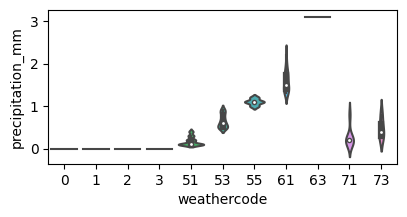

In [204]:
# try to plot by weather code
# Present Weather (WMO Code 4677) I guess

# 0: Cloud development not observed or not observable *
# 1: Clouds generally dissolving or becoming less developed *
# 2: State of sky on the whole unchanged *
# 3: Clouds generally forming or developing *
# 51: Drizzle, not freezing, continuous slight at time of observation
# 53: Drizzle, not freezing, continuous moderate at time of observation
# 55: Drizzle, not freezing, continuous heavy (dence) at time of observation
# 61: Rain, not freezing, continous slight at time of observation
# 63: Rain, not freezing, continuous moderate at time of observation
# 71: Continuous fall of snow flakes slight at time of observation
# 73: Continuous fall of snow flakes moderate at time of observation

sns.violinplot(data=df_weather, x='weathercode', y='precipitation_mm')

<AxesSubplot: xlabel='weathercode', ylabel='cloudcover_perc'>

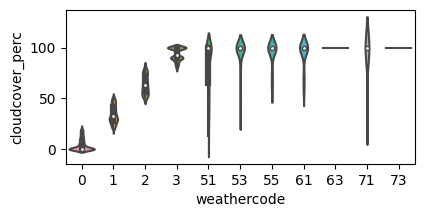

In [205]:
sns.violinplot(data=df_weather, x='weathercode', y='cloudcover_perc')

<AxesSubplot: xlabel='weathercode', ylabel='time_ms'>

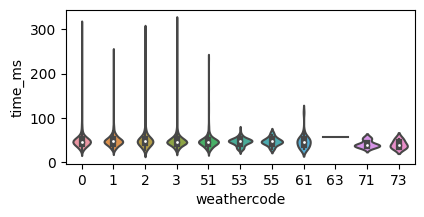

In [206]:
sns.violinplot(data=combined_ping_df, x='weathercode', y='time_ms')

<AxesSubplot: xlabel='weathercode', ylabel='ping_jitter'>

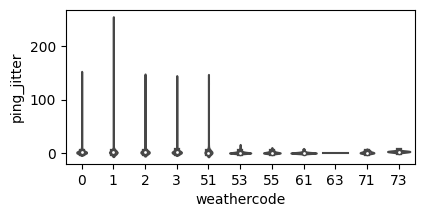

In [207]:
sns.violinplot(data=combined_bandwidth_df, x='weathercode', y='ping_jitter')

<AxesSubplot: xlabel='weathercode', ylabel='ping_latency'>

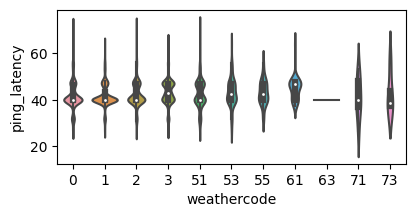

In [208]:
sns.violinplot(data=combined_bandwidth_df, x='weathercode', y='ping_latency')

<AxesSubplot: xlabel='weathercode', ylabel='download_bandwidth'>

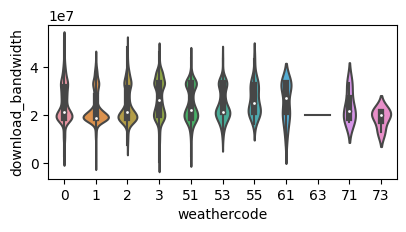

In [209]:
sns.violinplot(data=combined_bandwidth_df, x='weathercode', y='download_bandwidth')

<AxesSubplot: xlabel='weathercode', ylabel='upload_bandwidth'>

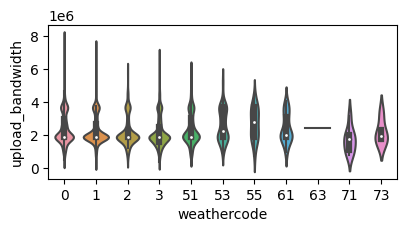

In [210]:
sns.violinplot(data=combined_bandwidth_df, x='weathercode', y='upload_bandwidth')